In [74]:
%time
import sagemaker
from sagemaker import get_execution_role
import boto3

role = get_execution_role()
print(role)
sess = sagemaker.Session()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
arn:aws:iam::243524247240:role/service-role/AmazonSageMaker-ExecutionRole-20200326T103074


In [75]:
from sagemaker.amazon.amazon_estimator import get_image_uri
training_image = get_image_uri(sess.boto_region_name, 'semantic-segmentation', repo_version="latest")
print (training_image)

544295431143.dkr.ecr.ap-southeast-2.amazonaws.com/semantic-segmentation:latest


In [76]:
bucket = 'pipe-line-test'
prefix = 'ss-demo-human-yes'
print(bucket)

pipe-line-test


The number of jpeg images in train and png images in train_annotation must be the same, and so in validation as well.

In [77]:
#import glob
#num_training_samples=len(glob.glob1('train',"*.jpg"))
#print ( ' Num Train Images = ' + str(num_training_samples))
#assert num_training_samples == len(glob.glob1('train_annotation',"*.png"))
#print ( ' Num Validation Images = ' + str(len(glob.glob1('validation',"*.jpg"))))
#assert len(glob.glob1('validation',"*.jpg")) == len(glob.glob1('validation_annotation',"*.png"))

num_training_samples = len(sess.list_s3_files(bucket, prefix + '/train')) // 2
print ( ' Num Train Images = ' + str(num_training_samples))

num_training_annotation_samples = len(sess.list_s3_files(bucket, prefix + '/train_annotation'))
print ( ' Num Train annotation Images = ' + str(num_training_annotation_samples))

assert num_training_samples == num_training_annotation_samples

num_validation_samples = len(sess.list_s3_files(bucket, prefix + '/validation')) // 2
print ( ' Num validation Images = ' + str(num_validation_samples))

num_validation_annotation_samples = len(sess.list_s3_files(bucket, prefix + '/validation_annotation'))
print ( ' Num validation annotation Images = ' + str(num_validation_annotation_samples))

assert num_validation_samples == num_validation_annotation_samples

 Num Train Images = 1662
 Num Train annotation Images = 1662
 Num validation Images = 416
 Num validation annotation Images = 416


544295431143.dkr.ecr.ap-southeast-2.amazonaws.com/semantic-segmentation:latest


In [78]:
# Create channel names for the s3 bucket.
train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'
# label_map_channel = prefix + '/label_map'

In [41]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
print(s3_output_location)

s3://pipe-line-test/ss-demo-human-yes/output


In [80]:
# Create the sagemaker estimator object.
ss_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count = 1, 
                                         train_instance_type = 'ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         output_path = s3_output_location,
                                         base_job_name = 'pipeline',
                                         sagemaker_session = sess)

In [44]:
# Setup hyperparameters 
ss_model.set_hyperparameters(backbone='resnet-50', # This is the encoder. Other option is resnet-50
                             algorithm='fcn', # This is the decoder. Other option is 'psp' and 'deeplab'                             
                             use_pretrained_model='True', # Use the pre-trained model.
                             crop_size=240, # Size of image random crop.                             
                             num_classes=2, # This is a mandatory parameter.
                             epochs=10, # Number of epochs to run.
                             learning_rate=0.0001,                             
                             optimizer='rmsprop', # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
                             lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
                             mini_batch_size=16, # Setup some mini batch size.
                             validation_mini_batch_size=16,
                             early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
                             early_stopping_patience=2, # Tolerate these many epochs if the mIoU doens't increase.
                             early_stopping_min_epochs=10, # No matter what, run these many number of epochs.                             
                             num_training_samples=num_training_samples) # This is a mandatory parameter.

In [45]:
# Create full bucket names
s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

distribution = 'FullyReplicated'
# Create sagemaker s3_input objects
train_data = sagemaker.session.s3_input(s3_train_data, distribution=distribution, 
                                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution=distribution, 
                                        content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution=distribution, 
                                        content_type='image/png', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution=distribution, 
                                        content_type='image/png', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 
                 'validation': validation_data,
                 'train_annotation': train_annotation, 
                 'validation_annotation':validation_annotation}

The data logs will also print out training loss on the training data, which is the pixel-wise cross-entropy loss as described in the algorithm papers. The data logs will also print out pixel-wise label accuracy and mean intersection-over-union (mIoU) on the validation data after a run of the dataset once or one epoch. These metrics measure the quality of the model under training.

Once the job has finished a "Job complete" message will be printed. The trained model can be found in the S3 bucket that was setup as output_path in the estimator.

In [46]:
ss_model.fit(inputs=data_channels, logs=True)

2020-03-26 03:43:23 Starting - Starting the training job...
2020-03-26 03:43:25 Starting - Launching requested ML instances......
2020-03-26 03:44:25 Starting - Preparing the instances for training......
2020-03-26 03:45:26 Downloading - Downloading input data...
2020-03-26 03:46:13 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[03/26/2020 03:46:36 INFO 139635873756992] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'syncbn': u'False', u'gamma2': u'0.9', u'gamma1': u'0.9', u'early_stopping_min_epochs': u'5', u'epochs': u'10', u'_workers': u'16', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0001', u'crop_size': u'240', u'use_pretrained_model': u'True', u'_aux_weight': u'0.5', u'_hybrid': u'False', u'_augmentation_type': u'default', u'lr_scheduler': u'poly', u'early_stopping_patience

Hosting
Once the training is done, we can deploy the trained model as an Amazon SageMaker hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same instance (or type of instance) that we used to train. Training is a prolonged and compute heavy job that require a different of compute and memory requirements that hosting typically do not

In [47]:
ss_predictor = ss_model.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge')

---------------!

Inference
Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference

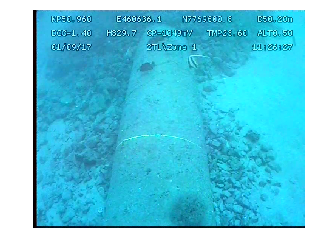

In [71]:
filename = 'test.jpg'
import matplotlib.pyplot as plt

import PIL

# resize image size for inference
im = PIL.Image.open(filename)
im.thumbnail([800,600],PIL.Image.ANTIALIAS)
im.save(filename, "JPEG")


%matplotlib inline
plt.imshow(im)
plt.axis('off')
with open(filename, 'rb') as image:
    img = image.read()
    img = bytearray(img)

The endpoint accepts images in formats similar to the ones found images in the training dataset. It accepts the image/jpeg content_type. The accept parameter takes on two values: image/png and application/x-protobuf. For customers who want an indexed-PNG segmentation mask such as the ones that were used during training, can use the image/png accept type as shown in the example below. Using this endpoint will return a image bytearray.

In [72]:
%%time 
ss_predictor.content_type = 'image/jpeg'
ss_predictor.accept = 'image/png'
return_img = ss_predictor.predict(img)

CPU times: user 4.44 ms, sys: 226 µs, total: 4.66 ms
Wall time: 8.69 s


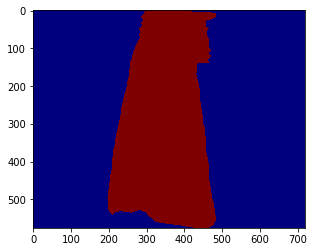

In [73]:
from PIL import Image
import numpy as np
import io

num_classes = 2
mask = np.array(Image.open(io.BytesIO(return_img)))
plt.imshow(mask, vmin=0, vmax=num_classes-1, cmap='jet')
plt.show()

The second accept type allows us to request all the class probabilities for each pixels. Let us use our endpoint to try to predict the probabilites of segments within this image. Since the image is jpeg, we use the appropriate content_type to run the prediction job. The endpoint returns a file that we can simply load and peek into.

In [65]:
%%time
# resize image size for inference
im = PIL.Image.open(filename)
im.thumbnail([800,600],PIL.Image.ANTIALIAS)
im.save(filename, "JPEG")
with open(filename, 'rb') as image:
    img = image.read()
    img = bytearray(img)
    
ss_predictor.content_type = 'image/jpeg'
ss_predictor.accept = 'application/x-protobuf'
results = ss_predictor.predict(img)

CPU times: user 167 ms, sys: 48.3 ms, total: 215 ms
Wall time: 11.8 s


What we receive back is a recordio-protobuf of probablities sent as a binary. It takes a little bit of effort to convert into a readable array. Let us convert them to numpy format. We can make use of mxnet that has the capability to read recordio-protobuf formats. Using this, we can convert the outcoming bytearray into numpy array.

In [66]:
from sagemaker.amazon.record_pb2 import Record
import mxnet as mx

results_file = 'results.rec'
with open(results_file, 'wb') as f:
    f.write(results)

rec = Record()
recordio = mx.recordio.MXRecordIO(results_file, 'r')
protobuf = rec.ParseFromString(recordio.read())

The protobuf array has two parts to it. The first part contains the shape of the output and the second contains the values of probabilites. Using the output shape, we can transform the probabilities into the shape of the image, so that we get a map of values. There typically is a singleton dimension since we are only inferring on one image. We can also remove that using the squeeze method.

In [67]:
values = list(rec.features["target"].float32_tensor.values)
shape = list(rec.features["shape"].int32_tensor.values)
shape = np.squeeze(shape)
mask = np.reshape(np.array(values), shape)
mask = np.squeeze(mask, axis=0)

So as to plot the segmentation mask from the list of probabilities, let us get the indices of the most probable class for each pixel. We can do this by measuring the argmax across the classes axis of the probability data. To plot the probabilites as image, we can use the numpy.argmax method to find out which probabilities are the largest and plot only those as a segmentaiton mask.

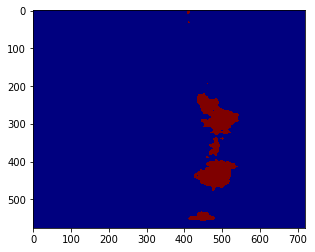

In [68]:
pred_map = np.argmax(mask, axis=0)
num_classes = 2
plt.imshow(pred_map, vmin=0, vmax=num_classes-1, cmap='jet')
plt.show()

In [58]:
#sagemaker.Session().delete_endpoint(ss_predictor.endpoint)

In [ ]:
#wswdwdwdwd

In [61]:
print(protobuf)

34836529
